In [1]:
from __future__ import annotations
%pylab inline
import cv2
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [2]:
from collections import namedtuple

Rect = namedtuple("Rect", "x y w h")

def rects_overlap(r1: Rect, r2: Rect, g: int = 0) -> bool:
    """Checks if two rectangles overlap / touch each other.
    
    :param r1: rectangle 1
    :param r2: rectangle 2
    :param g: allowed gap between the two rectangles
    :return: True if rectangles touch each other
    
    """
    x00, y00, x01, y01 = r1.x, r1.y, r1.x + r1.w, r1.y + r1.h
    x10, y10, x11, y11 = r2.x, r2.y, r2.x + r2.w, r2.y + r2.h
    
    return (
        x10 - x01 <= g and x00 - x11 <= g and y10 - y01 <= g and y00 - y11 <= g
    )

In [3]:
def combine_rects(rects):
    """Combine all rectangles that touch each other."""
    # allowed gap between rectangles
    gap = 5
    overlapping_rects = set()
    res = []
    
    while True:
        # find overlapping rects
        for i0, (x0, y0, w0, h0) in enumerate(rects):
            overlaps = False
            for i1, (x1, y1, w1, h1) in enumerate(rects):

                if i0 == i1: 
                    continue
                r0 = Rect(x0, y0, w0, h0)
                r1 = Rect(x1, y1, w1, h1)

                if rects_overlap(r0, r1, g=gap):
                    # print(f"Rects {i0} and {i1} overlap")
                    new_x = min(x0, x1)
                    new_y = min(y0, y1)
                    new_w = max(x0 + w0, x1 + w1) - new_x
                    new_h = max(y0 + h0, y1 + h1) - new_y
                    
                    new_rect = (new_x, new_y, new_w, new_h)
                    
                    new_rects = [x for i, x in enumerate(rects) if i not in (i0, i1)]
                    new_rects.append(new_rect)
                    rects = new_rects
                    overlaps = True
                    break
            if overlaps:
                break
        else:
            break
    return rects

In [4]:
def crop_rect(im, rect, border: int = 20):
    """Crop a rectangle from an image."""
    x, y, w, h = rect
    b = border
    d = int(abs((w - h) / 2))
    if w > h:
        im_cropped = im.copy()[y-b-d:y+b+w, x-b:x+b+w]
    else:
        im_cropped = im.copy()[y-b:y+b+h, x-b-d:x+b+h-d]
    return im_cropped

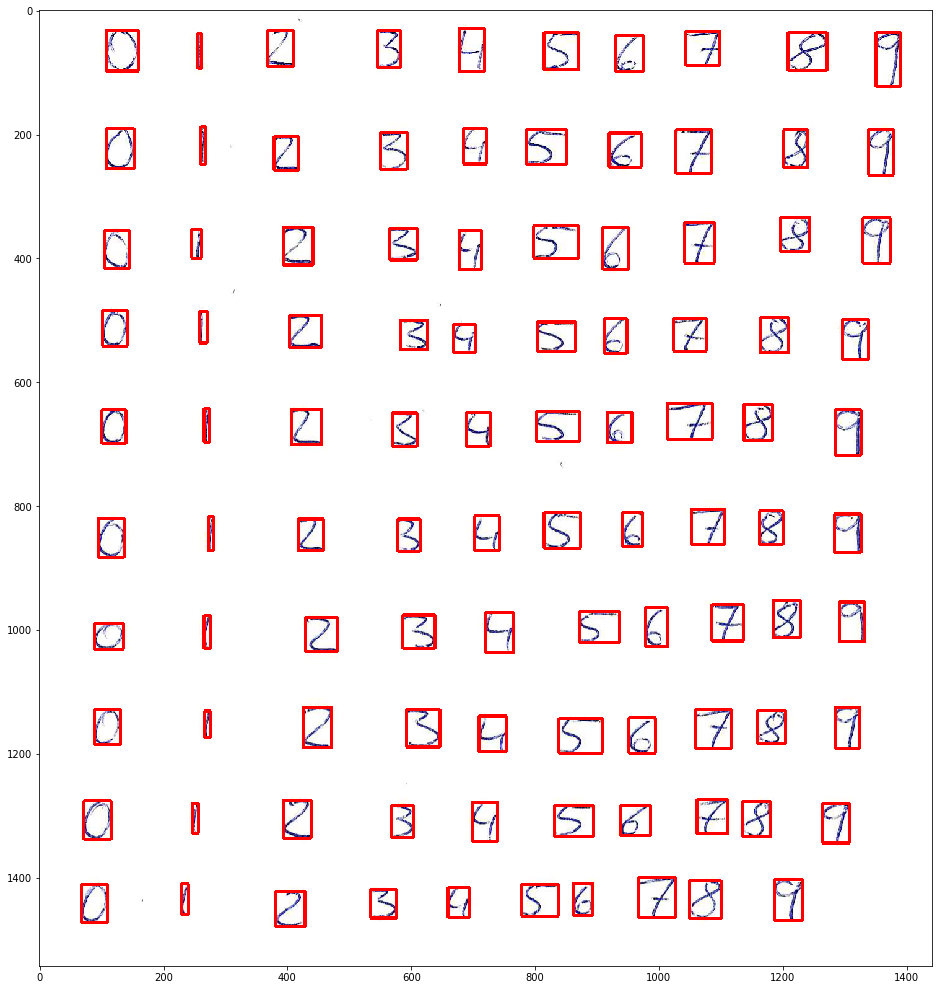

In [5]:
figsize(16, 20)
min_width_height = 5

# read original image
im_org = mpimg.imread("handwritten.bmp")

# convert to grayscale
im_gray = cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY)

# blur
blur = cv2.GaussianBlur(im_gray, (3, 3), cv2.BORDER_DEFAULT)

# convert to binary
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 10)

# find contours and rectangles around them
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rects = combine_rects([cv2.boundingRect(cont) for cont in contours])
rects = [x for x in rects if x[2] > min_width_height and x[3] > min_width_height]

for x, y, w, h in rects:
    cv2.rectangle(im_org, (x, y), (x + w, y + h),(255, 0, 0), 3)
imshow(im_org);

cropped_numbers = [crop_rect(im_gray, rect) for rect in rects]
resized_numbers = [cv2.resize(im.copy(), (28, 28)) for im in cropped_numbers]

In [6]:
def rect_in_row(rect, row):
    """Check if a rectangle lies in a certain row."""
    if len(row):
        mid = np.mean([y + h / 2 for (x, y, w, h) in row])
        tol = np.mean([h / 2 for (_, _, _, h) in row])
        x, y, w, h = rect
        if (y + h / 2) <= mid + tol and (y + h / 2) >= mid - tol:
            return True
        else:
            return False
    return True
 
# sort the numbers by row
rows = []
for rect in rects:
    for row in rows:
        if rect_in_row(rect, row):
            row.append(rect)
            break
    else:
        rows.append([rect])
        
# sort numbers in row by x coordinate
for i in range(len(rows)):
    
    rows[i] = sorted(rows[i])

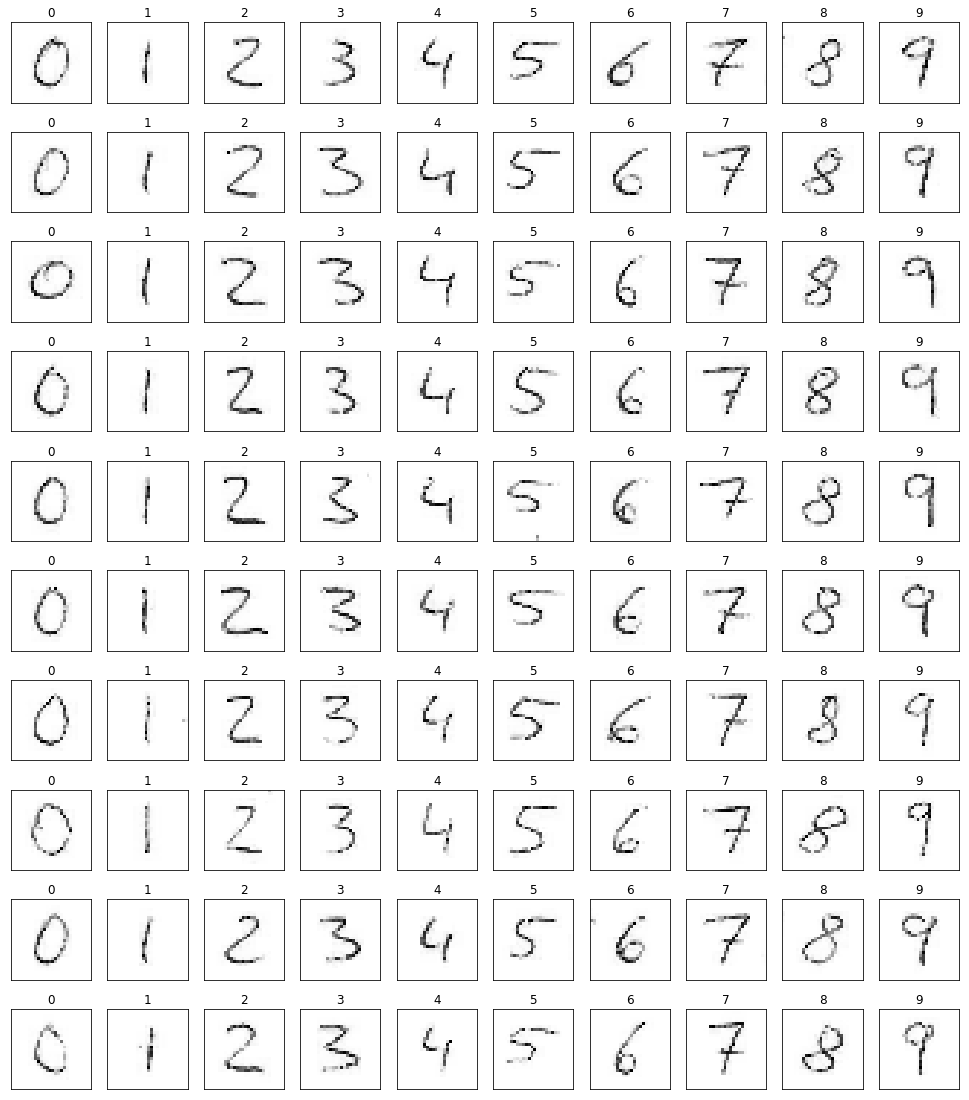

In [7]:
"""Crop all numbers and list them by row and column."""

figure(781, figsize=(17, 40))
ROWS = 20
COLS = 10

i = 0
for i_row, row in enumerate(rows, 1):
    cropped = [crop_rect(im_gray, rect) for rect in row]
    resized = [cv2.resize(im.copy(), (28, 28)) for im in cropped]
    for i, im in enumerate(resized):
        subplot(ROWS, COLS, 10 * (i_row - 1) + i + 1)
        title(f"{i}")
        xticks([], [])  # remove xticks
        yticks([], [])  # remove yticks
        imshow(im, cmap="gray")      


In [8]:
X = []
y = []
for row in rows:
    cropped = [crop_rect(im_gray, rect) for rect in row]
    resized = [cv2.resize(im.copy(), (28, 28)) for im in cropped]            
    for label, im in enumerate(resized):
        X.append(im)
        y.append(label)

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

In [9]:
X.shape, y.shape

((100, 28, 28), (100,))

Looks great. Now we save this to file.

In [10]:
import pickle
with open("handwritten.pkl", "wb") as f:
    pickle.dump((X, y), f)